In [23]:
#!pip install pandas
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 6.0 MB/s eta 0:00:00:00:01


In [3]:
# Importando as bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from control.matlab import *
from control.statesp import *


[1] - Malha fechada com LQG ou [2] - Malha aberta: 
    Eigenvalue (pole)       Damping     Frequency
     0.885   +0.3249j        0.1652         7.135
     0.885   -0.3249j        0.1652         7.135
SIMULANDO MALHA DE CONTROLE
O valor de ISE calculado para a malha de controle é: 18687.5904
O valor de IAE calculado para a malha de controle é: 4246.3229
O valor de ISU calculado para a malha de controle é: 4480.0000
O valor de TVC calculado para a malha de controle é: 5.0000


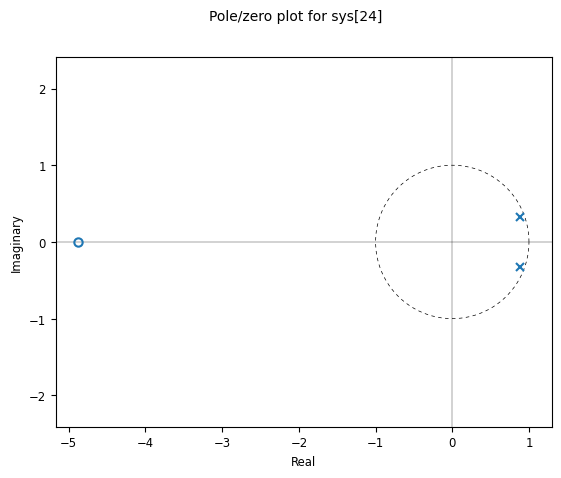

In [49]:
print('[1] - Malha fechada com LQG ou [2] - Malha aberta: ') 
n = int(input('Entre com a malha de controle a ser simulada: '))

#
Az = [1.0, -1.77, 0.8888]
Bz = [0.02101, 0.1025]
Cz = [1.0, -0.01519, -0.00462]
Ts = 0.05
d = int(1.0)
umax = 5.0
umin = -5.0

Az = np.array(Az)
Bz = np.array(Bz)
Cz = np.array(Cz)

#
a1 = Az[1]
a2 = Az[2]
b0 = Bz[0]
b1 = Bz[1]
c1 = Cz[1]
c2 = Cz[2]

#
na = len(Az)-1
nb = len(Bz)
nc = len(Cz)-1

#
Gz = tf(Bz,Az,Ts)
pole(Gz)
zero(Gz)
pzmap(Gz)
wn, csi, poles = damp(Gz)
A, B, C, D = ssdata(Gz)

# Forma canonica controlavel
A = np.rot90(A,2)
G = np.flipud(B)
C = np.flipud(C)

# Matriz aumentada
A1 = np.concatenate((A, np.zeros([len(A),1],float)), axis=1)
A2 = np.concatenate((C@A, np.ones([1,1],float)), axis=1)
Aa = np.concatenate((A1, A2), axis=0)
Ga = np.concatenate((G, C@G), axis=0)
Ca = np.concatenate((np.zeros([1,len(A)],float), np.ones([1,1],float)), axis=1)

# Kalman
Qfk =  1.0*np.identity(3,float)
Rfk =  1.0*np.ones([1,1],float)
_,_,L = dare(Aa.T, Ca.T, Qfk, Rfk)
L = L.T

# LQR
Qlqr = 1.0*np.identity(3,float)
Rlqr = np.ones([1,1],float)
_,_,K = dare(Aa, Ga, Qlqr, Rlqr)
K = K

# Malha de controle simulada
print('SIMULANDO MALHA DE CONTROLE')

# Sinal de ref
yr1 = np.zeros([1,20],float)
yr2 = np.ones([1,280],float)
yr3 = 3*np.ones([1,300],float)
yr4 = 2*np.ones([1,300],float)
yr5 = np.ones([1,300],float)
yr = np.concatenate((yr1, yr2, yr3, yr4, yr5), axis = 1)
_, nit = yr.shape
nit = int(nit)


# Pertubação na entrada da planta
v1 = np.zeros([1,20],float)
v2 = np.zeros([1,280],float)
v3 = np.zeros([1,300],float)
v4 = np.zeros([1,300],float)
v5 = np.zeros([1,300],float)
v = np.concatenate((v1,v2,v3,v4,v5),axis=1)

# Inicializar vetores
u_v = np.zeros([1, nit],float)
y_v = np.zeros([1, nit],float)
x = np.zeros([len(A), nit],float)
x_est = np.zeros([len(Aa), nit],float)
dx = np.zeros([len(A), nit],float)
x_a = np.zeros([len(Aa), nit],float)
y = np.zeros([1, nit],float)
y_f = np.zeros([1, nit],float)
u = np.zeros([1, nit],float)
du = np.zeros([1, nit],float)
e = np.zeros([1, nit],float)
e_est = np.zeros([1, nit],float)


# Inicializar o vetor de tempo
t = np.arange(0,nit*Ts,Ts)
t = np.array(t,ndmin=2)

# Inicializar o vetor de ruído de saída
variancia = 10.0*1e-3
xi = np.random.normal(0.0,np.sqrt(variancia), size=(1,nit))

# Condições iniciais
for k in range(len(A)+int(d)):
    # Sistema nomminal
    y[0,k]=0
    x[:,k] = np.zeros([1,na],float)
    u[0,k] = 0
    
    # Sistema aumentado
    x_est[:,k] = np.zeros([1,na+1],float)
    x_a[:,k] =  np.zeros([1,na+1],float)
    y_f[0,k] = 0
    du[0,k] = 0
    
# Malha de controle
for k in range(len(A)+int(d), nit):
    x[:len(x),k:k+1] = A @ x[:len(x),k-1:k] + G*u[0,k-d]
    y[0,k] = (C@x[:len(x),k:k+1]).item()
    y_v[0,k] = y[0,k] + xi[0,k] + v[0,k]
    e[0,k] = yr[0,k] - y_v[0,k]
    
    if n == 1 : # Malha fechada
        # Lei de controle LQG
        # Filtro de Kalman
        x_a[:len(x_a),k:k+1] = (Aa-L@Ca)@x_a[:len(x_a),k-1:k]+Ga*du[0,k-d]+L*y_v[0,k-1]
        y_f[0,k] = (Ca@x_a[:len(x_a),k:k+1]).item()
        e_est[0,k] = y[0,k]-y_f[0,k]
        
        # LQR
        du[0,k] = (-K @ x_a[:len(x_a),k:k+1] + K[0,na]*yr[0,k]).item()
        u[0,k] = u[0,k-1]+du[0,k] # Sinal de controle
        
    elif n == 2:
        u[0,k] = yr[0,k]
        du[0,k] = u[0,k] - u[0,k-1]
        
    if u[0,k] >= umax:
        u[0,k] = umax
    elif u[0,k] <= umin:
        u[0,k] = umin

# Índices de desempenho
ISE = np.sum(e @ e.T)
IAE = np.sum(np.absolute(e))
ISU = np.sum(u @ u.T)
TVC = np.sum(np.absolute(du))

# Apresenta os valores calculados
print("O valor de ISE calculado para a malha de controle é: {:.4f}".format(ISE))
print("O valor de IAE calculado para a malha de controle é: {:.4f}".format(IAE))
print("O valor de ISU calculado para a malha de controle é: {:.4f}".format(ISU))
print("O valor de TVC calculado para a malha de controle é: {:.4f}".format(TVC))
        

In [50]:
u

array([[0., 0., 0., ..., 1., 1., 1.]])

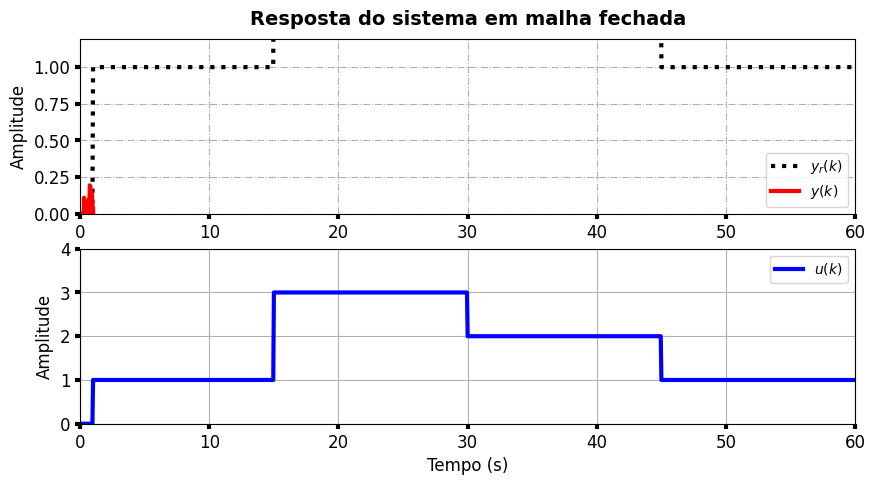

In [51]:
# Gerar gráficos 

plt.rc(
    'axes',
    labelweight = 'normal',
    labelsize = 'large',
    titleweight = 'bold',
    titlesize = 14,
    titlepad = 10,
    labelcolor = 'k',
)

if n==1:
    title = 'Resposta do sistema em malha fechada'
elif n==2:
    title = 'Resposta do sistema em malha aberta'

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
ax1.plot(t.T, yr.T,':k', t.T,y_v.T,'r',linewidth=3)
ax1.axis([0,60,0,np.max(y_v)+1])
ax1.legend(['$y_r(k)$', '$y(k)$'])
ax1.set(ylabel='Amplitude', title='Resposta do sistema em malha fechada')
ax1.grid(True, linestyle='-.')
ax1.tick_params(labelcolor='k', labelsize='large', width=3)

ax2.plot(t.T, u.T,'b',linewidth=3)
plt.axis([0,60,np.min(u),np.max(u)+1])
ax2.legend(['$u(k)$'])
ax2.set(ylabel='Amplitude', xlabel='Tempo (s)')
ax2.grid(True, linestyle='-')
ax2.tick_params(labelcolor='k', labelsize='large', width=3)


fig.savefig('LQG_control.png', dpi=300)

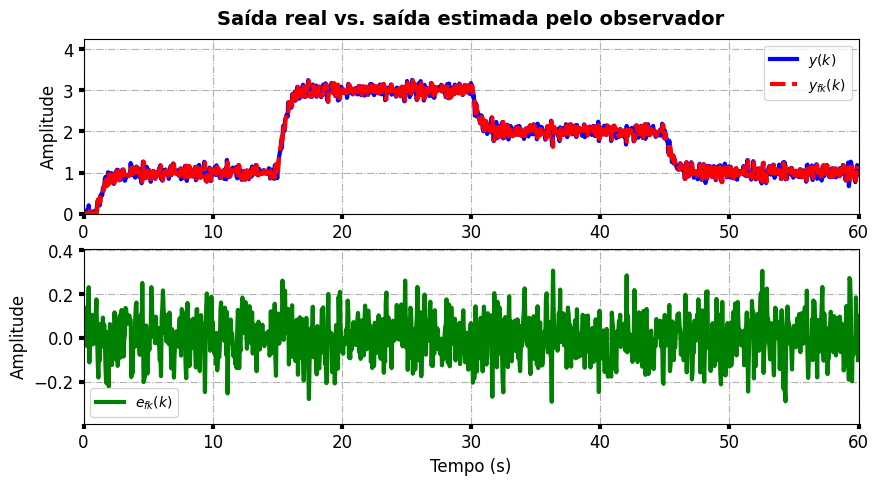

In [47]:
C# Gerar gráficos 

plt.rc(
    'axes',
    labelweight = 'normal',
    labelsize = 'large',
    titleweight = 'bold',
    titlesize = 14,
    titlepad = 10,
    labelcolor = 'k',
)

if n==1:
    titulo = 'Resposta do sistema em malha fechada'
elif n==2:
    titulo = 'Resposta do sistema em malha aberta'

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
ax1.plot(t.T, y_v.T,'b', t.T,y_f.T,'r--',linewidth=3)
ax1.axis([0,60,0,np.max(y_v)+1])
ax1.legend(['$y(k)$', '$y_{fk}(k)$'])
ax1.set(ylabel='Amplitude', title='Saída real vs. saída estimada pelo observador')
ax1.grid(True, linestyle='-.')
ax1.tick_params(labelcolor='k', labelsize='large', width=3)

ax2.plot(t.T, e_est.T,'g',linewidth=3)
plt.axis([0,60,np.min(e_est)-0.1,np.max(e_est)+0.1])
ax2.legend(['$e_{fk}(k)$'])
ax2.set(ylabel='Amplitude', xlabel='Tempo (s)')
ax2.grid(True, linestyle='-.')
ax2.tick_params(labelcolor='k', labelsize='large', width=3)


fig.savefig('LQG_control.png', dpi=300)

In [24]:
dados = {'yr':list(yr.T), 'u':list(u.T),'y':list(y_v.T), 't': list(t.T)}
lqg_df = pd.DataFrame(data=dados)
lqg_df.to_excel('LQG Dados.xlsx', index=False)


In [25]:
lqg_df = pd.read_excel('LQG Dados.xlsx')
display(lqg_df.tail(10))

,yr,u,y,t
1190,[1.],[-1.04889919],[1.00826259],[59.5]
1191,[1.],[-0.8983571],[1.08130613],[59.55]
1192,[1.],[-0.82735037],[1.01281195],[59.6]
1193,[1.],[-0.99473018],[1.14240875],[59.65]
1194,[1.],[-0.88420449],[0.90766859],[59.7]
1195,[1.],[-1.16513523],[1.05681436],[59.75]
1196,[1.],[-0.94811518],[0.81982519],[59.8]
1197,[1.],[-1.16053778],[0.85998697],[59.85]
1198,[1.],[-1.06527053],[1.11708078],[59.9]
1199,[1.],[-0.69960836],[0.88210456],[59.95]
